In [219]:
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as mtick

In [220]:
val_cov = (
    "/Users/julia/Desktop/Masterarbeit/snakemake/data/cluster_results/cascade/covid_data/fmsan/results/results.sqlite3",
    "/Users/julia/Desktop/Masterarbeit/snakemake/data/cluster_results/cascade/covid_data/fmsan/plots/", 
    "Covid Data FMSAN"
)

val_cov_smsan = (
    "/Users/julia/Desktop/Masterarbeit/snakemake/data/cluster_results/cascade/covid_data/smsan/results/results.sqlite3",
    "/Users/julia/Desktop/Masterarbeit/snakemake/data/cluster_results/cascade/covid_data/smsan/plots/", 
    "Covid Data SMSAN"
)

val_354 = (
    "/Users/julia/Desktop/Masterarbeit/snakemake/data/cluster_results/ml/354/results/results.sqlite3", 
    "/Users/julia/Desktop/Masterarbeit/snakemake/data/cluster_results/ml/354/plots/",
    "354"
)

val_tut = (
    "/Users/julia/Desktop/Masterarbeit/snakemake/data/ng-tutorial/results/results.sqlite3", 
    "/Users/julia/Desktop/Masterarbeit/snakemake/data/ng-tutorial/plots/",
    "Ng-tutorial"
)

DB_PATH, PLOT_PATH, DATASET_NAME = val_tut

In [221]:
# convert sqlite database to pandas dataframe
con = sqlite3.connect(DB_PATH)

runs = pd.read_sql_query("SELECT * FROM run", con)

raxmls = pd.read_sql_query("SELECT * FROM raxmlng", con)
raxml_treesearch_trees = pd.read_sql_query("SELECT * FROM raxmltreesearchtree", con)
raxml_eval_trees = pd.read_sql_query("SELECT * FROM raxmlevaltree", con)

iqtrees = pd.read_sql_query("SELECT * FROM iqtree", con)
iqtree_treesearch_trees = pd.read_sql_query("SELECT * FROM iqtreetreesearchtree", con)
iqtree_eval_trees = pd.read_sql_query("SELECT * FROM iqtreeevaltree", con)

rfdist_raxml_treesearch_trees = pd.read_sql_query("SELECT * FROM rfdisttreesearchtree", con)
rfdist_raxml_eval_trees = pd.read_sql_query("SELECT * FROM rfdistevaltree", con)

Merge Run, Raxmlng and Iqtree

In [222]:
summary = runs.merge(raxmls, left_on="id", right_on="run_id", suffixes=("_run", "_raxml"))
summary = summary.merge(iqtrees, left_on="id_run", right_on="run_id", suffixes=("", "_iqtree"))
summary = summary.rename(columns={
    "best_treesearch_llh": "best_treesearch_llh_raxml",
    "best_evaluation_llh": "best_evaluation_llh_raxml",
    "treesearch_total_time": "treesearch_total_time_raxml",
    "id": "id_iqtree"
})
summary.treesearch_total_time_raxml = summary.treesearch_total_time_raxml.round().astype(int)
summary.treesearch_total_time_iqtree = summary.treesearch_total_time_iqtree.round().astype(int)

### Raxml
Merge summary with RaxmlTreesearchTrees and RaxmlEvalTrees

In [223]:
raxml_tree_summary = summary.merge(raxml_treesearch_trees, left_on="id_raxml", right_on="program_id")
raxml_tree_summary = raxml_tree_summary.merge(raxml_eval_trees, left_on="id", right_on="start_tree_id", suffixes=("_treesearch", "_eval"))
best_raxml = raxml_tree_summary.loc[raxml_tree_summary.is_best_eval == True]

best_raxml = best_raxml.rename(columns={
    "best_treesearch_llh_raxml": "max_llh_search",
    "best_evaluation_llh_raxml": "max_llh_eval",
    "treesearch_total_time_raxml": "total_time_search",
    "avg_rel_rfdist_treesearch": "avg_rfdist_search"
})

best_raxml.compute_time_eval = best_raxml.compute_time_eval.round().astype(int)

### Iqtree
Merge summary with IqtreeTreesearchTrees and IqtreeEvalTrees

In [224]:
iqtree_tree_summary = summary.merge(iqtree_treesearch_trees, left_on="id_iqtree", right_on="program_id")
iqtree_tree_summary = iqtree_tree_summary.merge(iqtree_eval_trees, left_on="id", right_on="start_tree_id", suffixes=("_treesearch", "_eval"))
best_iqtree = iqtree_tree_summary.loc[iqtree_tree_summary.is_best_eval == True]

best_iqtree = best_iqtree.rename(columns={
    "best_treesearch_llh_iqtree": "max_llh_search",
    "best_evaluation_llh_iqtree": "max_llh_eval",
    "treesearch_total_time_iqtree": "total_time_search",
})
best_iqtree.compute_time_eval = best_iqtree.compute_time_eval.round().astype(int)

## Plot summary of all runs

In [225]:
def dataset_summary_table(df, progr_name, cols_to_use=None, col_width=2.3, row_height=0.625, font_size=16, bbox=[0, 0, 1, 1]):
    data = df
    if cols_to_use:
        data = data[cols_to_use]
    
    size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
    fig, ax = plt.subplots(figsize=size)
    ax.set_title(DATASET_NAME)
    ax.axis('off')

    table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns)

    table.auto_set_font_size(False)
    table.set_fontsize(font_size)
    plt.tight_layout() 
    fig.savefig(PLOT_PATH + f"dataset_summary_{progr_name}_table.pdf", format="pdf")
    fig.savefig(PLOT_PATH + f"dataset_summary_{progr_name}_table.svg", format="svg")


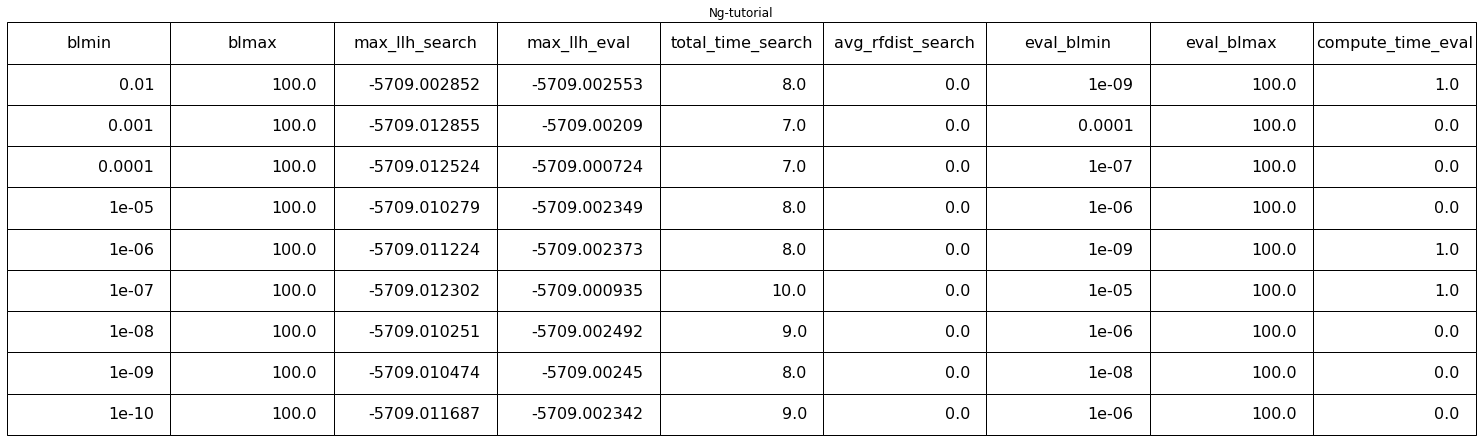

In [226]:
cols_to_plot = [
    "blmin", 
    "blmax", 
    "max_llh_search", 
    "max_llh_eval",
    "total_time_search",
    "avg_rfdist_search",
    "eval_blmin",
    "eval_blmax",
    "compute_time_eval"
]
dataset_summary_table(best_raxml, "raxml", cols_to_plot)

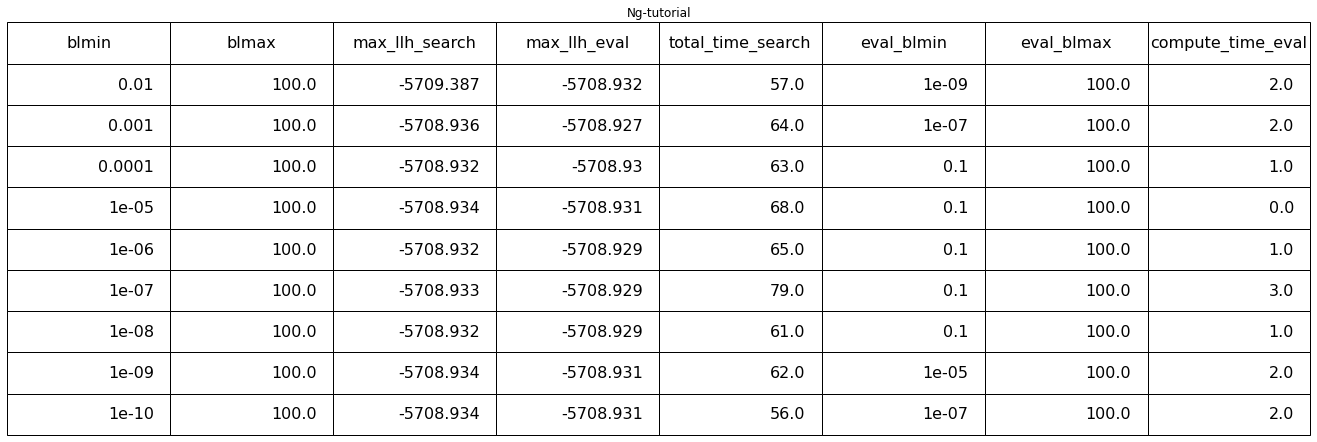

In [227]:
cols_to_plot = [
    "blmin", 
    "blmax", 
    "max_llh_search", 
    "max_llh_eval",
    "total_time_search",
    "eval_blmin",
    "eval_blmax",
    "compute_time_eval"
]
dataset_summary_table(best_iqtree, "iqtree", cols_to_plot)

## Llh plots

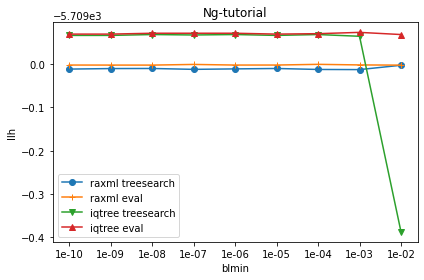

In [228]:
def plot_llhs(df):
    ax = plt.gca()
    ax.set_xlabel("blmin")    
    df.plot(style="o-", x="blmin", y="best_treesearch_llh_raxml", label="raxml treesearch", ax=ax, logx=True, xticks=df["blmin"], xlabel="blmin", ylabel="llh", title=DATASET_NAME)
    df.plot(style="+-", x="blmin", y="best_evaluation_llh_raxml", label="raxml eval", ax=ax)
    df.plot(style="v-", x="blmin", y="best_treesearch_llh_iqtree", label="iqtree treesearch", ax=ax)
    df.plot(style="^-", x="blmin", y="best_evaluation_llh_iqtree", label="iqtree eval", ax=ax)
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))
    
    plt.tight_layout() 
    fig = ax.get_figure()
    fig.savefig(PLOT_PATH + "llhs.pdf", format="pdf")
    fig.savefig(PLOT_PATH + "llhs.svg", format="svg")
   


plot_llhs(summary)

## Runtime plots

In [229]:
def plot_total_time(df, time_col_name, progr_name):
    ax = plt.gca()
    ax.set_xlabel("blmin")
    df.plot(kind="scatter", x="blmin", y=time_col_name, ax=ax, logx=True, xticks=df["blmin"], xlabel="blmin", ylabel="time (s)")
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))
    plt.title(DATASET_NAME) 
    plt.tight_layout() 
    fig = ax.get_figure()
    fig.savefig(PLOT_PATH + f"runtime_{progr_name}.pdf", format="pdf")  
    fig.savefig(PLOT_PATH + f"runtime_{progr_name}.svg", format="svg")  

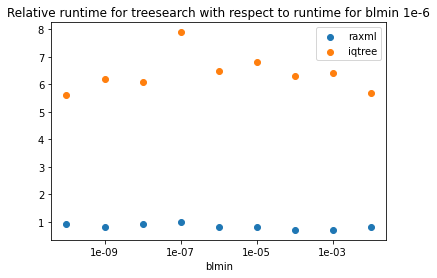

In [230]:
def plot_runtime_relative_to_reference(df, time_col_to_plot, time_name, reference_time, reference_time_name, progr_name):
    ax = plt.gca()
    ax.set_xlabel("blmin")
    ax.set_xticks(list(df["blmin"]))
    ax.set_xticklabels(list(df["blmin"]))
    plt.xscale("log")
    
    # calculate times relative to reference_time
    times = list(df[time_col_to_plot])
    rel_times = [t / reference_time for t in times]
    
    ax.scatter(x=list(df["blmin"]), y=rel_times, label=progr_name)
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))
    ax.legend()
    plt.title(f"Relative runtime for {time_name} with respect to runtime for {reference_time_name}")

    
plot_runtime_relative_to_reference(best_raxml, "total_time_search", "treesearch", 10, "blmin 1e-6", "raxml")
plot_runtime_relative_to_reference(best_iqtree, "total_time_search", "treesearch", 10, "blmin 1e-6", "iqtree")
    

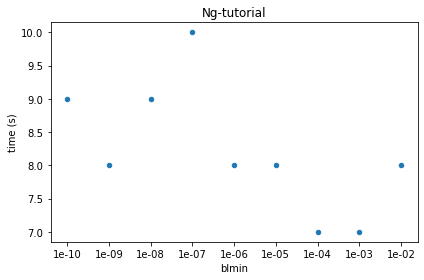

In [231]:
plot_total_time(best_raxml, "total_time_search", "raxml")

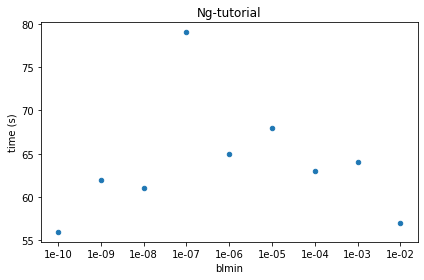

In [232]:
plot_total_time(best_iqtree, "total_time_search", "iqtree")

In [233]:
def get_blmin_for_eval_tree_id(eval_tree_id, progr_name):
    if progr_name == "raxml":
        eval_trees = raxml_eval_trees
        trees = raxml_treesearch_trees
        progr = raxmls
    elif progr_name == "iqtree":
        eval_trees = iqtree_eval_trees
        trees = iqtree_treesearch_trees
        progr = iqtrees
    eval_tree = eval_trees.loc[eval_trees.id == eval_tree_id]
    start_tree_id = eval_tree.start_tree_id.item()
    start_tree = trees.loc[trees.id == start_tree_id]
    progr_id = start_tree.program_id.item()
    program = progr.loc[progr.id == progr_id]
    run_id = program.run_id.item()
    run = runs.loc[runs.id == run_id]
    return run.blmin.item()

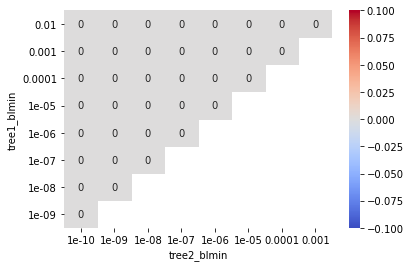

In [234]:
tree1_ids = []
tree2_ids = []
tree1_blmins = []
tree2_blmins = []
normalized_rf_distances = []
for idx, row in rfdist_raxml_eval_trees.iterrows():
    tree1_ids.append(row.tree1_id)
    tree1_blmins.append(get_blmin_for_eval_tree_id(row.tree1_id, "raxml"))
    tree2_ids.append(row.tree2_id)
    tree2_blmins.append(get_blmin_for_eval_tree_id(row.tree2_id, "raxml"))
    normalized_rf_distances.append(row.normalized_rfdist)

d = {
    "tree1_id": tree1_ids,
    "tree2_id": tree2_ids,
    "tree1_blmin": tree1_blmins,
    "tree2_blmin": tree2_blmins,
    "normalized_rfdist": normalized_rf_distances,
}
df = pd.DataFrame(data=d)

data = df.pivot("tree1_blmin", "tree2_blmin", "normalized_rfdist")

ax = plt.gca()
hmap = sns.heatmap(data, annot=True, cmap="coolwarm", ax=ax)
ax.invert_yaxis()

fig = ax.get_figure()

fig.savefig(PLOT_PATH + "rfdist_best_eval_trees.pdf", format="pdf", bbox_inches="tight") 
fig.savefig(PLOT_PATH + "rfdist_best_eval_trees.svg", format="svg", bbox_inches="tight") 

In [252]:
def plot_eval_llhs_for_varying_blmin(treesearch_blmin, progr_name):
    if progr_name == "raxml":
        program = raxmls
        trees = raxml_treesearch_trees
        eval_trees = raxml_eval_trees
    elif progr_name == "iqtree":
        program = iqtrees
        trees = iqtree_treesearch_trees
        eval_trees = iqtree_eval_trees
        
    r_id = runs.loc[runs.blmin == treesearch_blmin].id.item()
    program_id = program.loc[program.run_id == r_id].id.item()
    best_tree_id = trees.loc[(trees.program_id == program_id) & (trees.is_best == True)].id.item()
    
    eval_t = eval_trees.loc[(eval_trees.start_tree_id == best_tree_id)]
    eval_t = eval_t[["llh", "is_best", "eval_blmin"]]

    ax = plt.gca()
    ax.set_xlabel("eval_blmin") 
    eval_t.plot(style="o-", x="eval_blmin", y="llh", ax=ax, logx=True, xticks=eval_t["eval_blmin"], xlabel="eval_blmin", ylabel="llh", label=f"{progr_name}_llh", title=DATASET_NAME)
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))

    plt.tight_layout() 
    fig = ax.get_figure()
    fig.savefig(PLOT_PATH + f"{progr_name}_eval_llhs_for_start_blmin_{treesearch_blmin}.svg", format="svg")


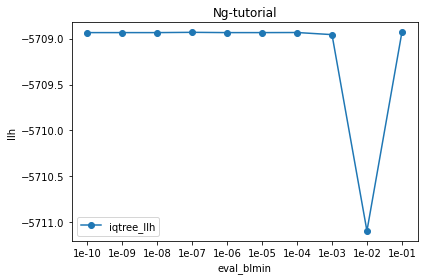

In [253]:
plot_eval_llhs_for_varying_blmin(1e-10, "iqtree")

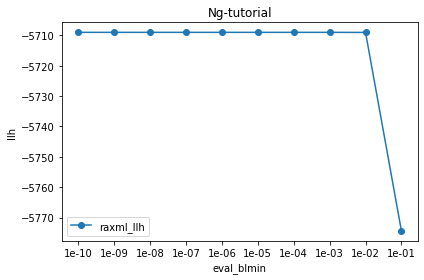

In [254]:
plot_eval_llhs_for_varying_blmin(1e-10, "raxml")